In [1]:
import time
start_time = time.time()

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from MultiTimeframeCandleManager import MultiTimeframeCandleManager
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
from tqdm import tqdm
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt

candles = obj_load("NQ_1")[600000:]
len(candles)

loading NQ_1


250000

In [3]:
num_actions = 3

In [4]:

lrelu = tf.keras.layers.LeakyReLU(0.05)


chart_m15 = tf.keras.layers.Input(shape = (60,4))
chart_m5 = tf.keras.layers.Input(shape = (60,4))
chart_m1 = tf.keras.layers.Input(shape = (60,4))

pdas = tf.keras.layers.Input(shape = (3*3+3*3+1+12*5+5*3,))

current_position = tf.keras.layers.Input(shape = (3,))

minutes = tf.keras.layers.Input(shape = (1,))
minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

f15 = tf.keras.layers.Flatten()(chart_m15)
f5 = tf.keras.layers.Flatten()(chart_m5)
f1 = tf.keras.layers.Flatten()(chart_m1)

pdas_repeated = tf.keras.layers.Lambda(
lambda inputs: tf.repeat(tf.expand_dims(inputs, axis = 1), repeats=60, axis=1)
)(pdas)

concatenated_m5_at = tf.keras.layers.Concatenate(axis=-1)([chart_m5, pdas_repeated])
m5_at = tf.keras.layers.Dense(512)(concatenated_m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(256)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(128)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.LSTM(512)(m5_at)

concatenated_m1_at = tf.keras.layers.Concatenate(axis=-1)([chart_m1, pdas_repeated])
m1_at = tf.keras.layers.Dense(512)(concatenated_m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(256)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(128)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.LSTM(512)(m1_at)


#c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, m1_at, m5_at])

d = tf.keras.layers.Dense(4096*4)(c)
d = lrelu(d)
d = tf.keras.layers.Dense(4096*4)(d)
d = lrelu(d)
d = tf.keras.layers.Dense(4096*2)(d)
d = lrelu(d)
d = tf.keras.layers.Dense(4096*1)(d)
d = lrelu(d)


value = tf.keras.layers.Dense(1, activation="linear")(d)
advantage = tf.keras.layers.Dense(num_actions, activation="linear")(d)

q_values = tf.keras.layers.Lambda(
lambda inputs: inputs[0] + (inputs[1] - tf.reduce_mean(inputs[1], axis=1, keepdims=True))
)([value, advantage])

outputs = tf.keras.layers.Activation('linear', dtype='float32')(q_values)

model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes, current_position], outputs = outputs)


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 60, 94)       0           ['input_4[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 60, 98)       0           ['input_3[0][0]',                
                                                                  'lambda[0][0]']             

In [5]:
model.load_weights("model.weights.h5")

In [6]:

def relative (value, center, r):
        return (value - center) / r

def ret_to_scaled_inputs(ret):

    midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret


    center = (midnight_opening_range_high + midnight_opening_range_low) / 2
    r = max(0.0001,(midnight_opening_range_high - midnight_opening_range_low) / 2)

    pda_rel = []
    pda_rel.append(relative(midnight_open, center, r))
    for pda in pdas[0:9+9+15]:
        pda_rel.append(relative(pda, center, r))
    for index in range(9+9+15,9+9+15+5*12):
        ## highs lows are like this [h, h_taken, l, l_taken]
        ## the bools should not be scaled
        if (index - 9+9+15) % 2 == 0:
            pda_rel.append(relative(pdas[index], center, r))
        else:
            pda_rel.append(pdas[index])

    pda_np = np.array(pda_rel)

    current_minutes = current_time.hour * 60 + current_time.minute

    charts_array = []
    for candlesticks in charts:
        charts_array.append([])
        for candle in candlesticks:
            o = relative(candle.o, center, r)
            h = relative(candle.h, center, r)
            l = relative(candle.l, center, r)
            c = relative(candle.c, center, r)
            charts_array[-1].append([o,h,l,c])

    m15_np = np.array(charts_array[0])
    m5_np = np.array(charts_array[1])
    m1_np = np.array(charts_array[2])

    return [m15_np, m5_np, m1_np, pda_np, current_minutes]


# In[11]:


class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction


In [7]:
def step(index):

        global current_position, current_order, slm, m, outputs, all_candles, cmm, equity, equity_L
    
        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)




        if(len(m.ndogs) == 5 and len(m.fps) == 3 and len(m.opening_range_gaps) == 3 and len(m.asia_highs_lows) == 3 and len(m.london_highs_lows) == 3 and len(m.ny_am_highs_lows) == 3 and len(m.ny_lunch_highs_lows) == 3 and len(m.ny_pm_highs_lows) == 3):


            open_profit = (current_close - current_position.entry) * current_position.direction

            scaled_entry_diff  =  0
            scaled_sl_diff  =  0
            if(current_position.direction != 0):
                scaled_entry_diff = (current_close - current_position.entry) / r
                scaled_sl_diff = (current_close - current_position.sl) / r

            state = ret_to_scaled_inputs(ret) + [np.array([current_position.direction, scaled_entry_diff, scaled_sl_diff])]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info = state

            equity_L.append(equity+open_profit)
            all_candles.append(charts[2][-1])


            if True:#current_minutes >= 9*60+29 and current_minutes < 16*60:
                output = inference_step(
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    tf.expand_dims(current_minutes, 0),
                    tf.expand_dims(pos_info, 0)
                )

                last_action = np.argmax(output)
                #last_action = np.argmax([output[0][0], output[0][1]])
                outputs.append(output[0])
            else:
                last_action = 2


            avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])[55:60]])

            if(last_action == 2 and current_position.direction != 0):
                equity += open_profit
                current_position = Position(0,0,0,0)
                #print("close position:", open_profit)

            if(last_action == 0 and current_position.direction == 1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 0 and current_position.direction == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None

                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) > 0):

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)


                    sl = entry + avg_candle_range * slm
                    tp = entry  -  abs(entry-sl) * 1000


                    current_order = Order(entry, sl, tp, -1)
                    #print("set short order:",entry,sl,tp)



            if(last_action == 1 and current_position.direction == -1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1 and current_position.direction == 0):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) > 0):
                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    sl = entry - avg_candle_range * slm
                    tp = entry  +  abs(entry-sl) * 1000

                    current_order = Order(entry, sl, tp, 1)
                    #print("set long order:",entry,sl,tp)



In [9]:
m = MultiTimeframeCandleManager()

slm = 1.5#1.5

current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

outputs = []
all_candles = []

cmm = 0.5

@tf.function()
def inference_step(m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info):
    return model([
        m15_np,
        m5_np,
        m1_np,
        pda_np,
        current_minutes,
        pos_info,
    ])



for index in tqdm(range(len(candles))):
    step(index)
    if( index % 100 == 0 ):
        print(equity_L[-1])

print(equity_L[-1])

  1%|▌                                                                         | 1793/250000 [00:00<00:30, 8069.78it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


  1%|█                                                                         | 3401/250000 [00:00<00:32, 7704.77it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


  2%|█▌                                                                        | 5207/250000 [00:00<00:29, 8383.58it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.0
0.0
0.0


  2%|█▌                                                                        | 5207/250000 [00:15<00:29, 8383.58it/s]

0.0


  2%|█▊                                                                         | 5910/250000 [00:16<25:40, 158.41it/s]

0.0
0.0


  2%|█▊                                                                        | 6152/250000 [00:55<3:06:10, 21.83it/s]

3.75
3.75
3.75


  3%|█▉                                                                        | 6419/250000 [01:05<2:50:58, 23.75it/s]

3.75


  3%|█▉                                                                        | 6604/250000 [01:17<3:15:46, 20.72it/s]

3.75


  3%|█▉                                                                        | 6606/250000 [01:17<3:16:33, 20.64it/s]

3.75


  3%|█▉                                                                        | 6735/250000 [01:26<3:38:47, 18.53it/s]

3.75


  3%|██                                                                        | 6889/250000 [01:45<5:19:25, 12.69it/s]

3.75


  3%|██                                                                        | 6990/250000 [01:48<3:51:07, 17.52it/s]

3.75


  3%|██                                                                        | 7103/250000 [01:55<4:24:53, 15.28it/s]

3.75


  3%|██▏                                                                       | 7207/250000 [02:02<2:00:59, 33.44it/s]

3.75


  3%|██▏                                                                       | 7307/250000 [02:05<1:49:25, 36.97it/s]

3.75


  3%|██▏                                                                       | 7405/250000 [02:07<1:50:48, 36.49it/s]

3.75


  3%|██▏                                                                       | 7506/250000 [02:10<1:50:29, 36.58it/s]

3.75


  3%|██▎                                                                       | 7605/250000 [02:14<2:24:44, 27.91it/s]

3.75


  3%|██▎                                                                       | 7705/250000 [02:18<3:09:40, 21.29it/s]

3.75


  3%|██▎                                                                       | 7805/250000 [02:20<1:33:53, 42.99it/s]

3.75


  3%|██▎                                                                       | 7905/250000 [02:23<1:30:38, 44.52it/s]

3.75


  3%|██▎                                                                       | 8007/250000 [02:25<1:45:54, 38.08it/s]

3.75


  3%|██▍                                                                       | 8107/250000 [02:27<1:26:56, 46.37it/s]

3.75


  3%|██▍                                                                       | 8203/250000 [02:31<4:31:35, 14.84it/s]

3.75


  3%|██▍                                                                       | 8304/250000 [02:33<1:28:18, 45.62it/s]

3.75


  3%|██▍                                                                       | 8406/250000 [02:36<2:02:25, 32.89it/s]

3.75


  3%|██▌                                                                       | 8509/250000 [02:38<1:36:11, 41.85it/s]

3.75


  3%|██▌                                                                       | 8607/250000 [02:41<1:41:25, 39.67it/s]

3.75


  3%|██▌                                                                       | 8707/250000 [02:43<1:27:32, 45.93it/s]

3.75


  4%|██▌                                                                       | 8808/250000 [02:46<1:33:23, 43.05it/s]

3.75


  4%|██▋                                                                       | 8907/250000 [02:49<1:35:57, 41.87it/s]

3.75


  4%|██▋                                                                       | 9007/250000 [02:51<1:28:12, 45.53it/s]

3.75


  4%|██▋                                                                       | 9107/250000 [02:53<1:29:25, 44.89it/s]

3.75


  4%|██▋                                                                       | 9207/250000 [02:55<1:29:19, 44.93it/s]

3.75


  4%|██▊                                                                       | 9308/250000 [02:58<1:32:29, 43.37it/s]

6.05000000000291


  4%|██▊                                                                       | 9408/250000 [03:00<1:43:26, 38.76it/s]

13.05000000000291


  4%|██▊                                                                       | 9507/250000 [03:03<1:42:06, 39.25it/s]

13.05000000000291


  4%|██▊                                                                       | 9602/250000 [03:05<1:57:38, 34.06it/s]

13.05000000000291


  4%|██▊                                                                       | 9706/250000 [03:08<1:30:12, 44.40it/s]

13.05000000000291


  4%|██▉                                                                       | 9806/250000 [03:10<1:28:49, 45.07it/s]

13.05000000000291


  4%|██▉                                                                       | 9906/250000 [03:12<1:28:45, 45.08it/s]

13.05000000000291


  4%|██▉                                                                      | 10007/250000 [03:15<1:56:07, 34.44it/s]

13.05000000000291


  4%|██▉                                                                      | 10107/250000 [03:17<1:30:07, 44.36it/s]

13.05000000000291


  4%|██▉                                                                      | 10207/250000 [03:19<1:28:31, 45.15it/s]

13.05000000000291


  4%|███                                                                      | 10307/250000 [03:22<1:39:58, 39.96it/s]

13.05000000000291


  4%|███                                                                      | 10408/250000 [03:24<1:31:15, 43.76it/s]

13.05000000000291


  4%|███                                                                      | 10503/250000 [03:27<1:35:40, 41.72it/s]

13.05000000000291


  4%|███                                                                      | 10607/250000 [03:30<1:46:02, 37.63it/s]

13.05000000000291


  4%|███▏                                                                     | 10706/250000 [03:33<1:37:23, 40.95it/s]

13.05000000000291


  4%|███▏                                                                     | 10806/250000 [03:35<1:29:26, 44.57it/s]

13.05000000000291


  4%|███▏                                                                     | 10906/250000 [03:37<1:28:35, 44.98it/s]

13.05000000000291


  4%|███▏                                                                     | 11006/250000 [03:40<1:41:53, 39.09it/s]

13.05000000000291


  4%|███▏                                                                     | 11108/250000 [03:42<1:30:26, 44.02it/s]

13.05000000000291


  4%|███▎                                                                     | 11208/250000 [03:44<1:29:36, 44.42it/s]

13.05000000000291


  5%|███▎                                                                     | 11308/250000 [03:47<1:29:56, 44.23it/s]

13.05000000000291


  5%|███▎                                                                     | 11406/250000 [03:49<1:53:24, 35.06it/s]

13.05000000000291


  5%|███▎                                                                     | 11505/250000 [03:52<1:41:48, 39.04it/s]

13.05000000000291


  5%|███▍                                                                     | 11606/250000 [03:54<1:30:18, 44.00it/s]

13.05000000000291


  5%|███▍                                                                     | 11704/250000 [03:57<2:56:14, 22.53it/s]

13.05000000000291


  5%|███▍                                                                     | 11804/250000 [04:00<1:32:22, 42.98it/s]

13.05000000000291


  5%|███▍                                                                     | 11906/250000 [04:02<1:39:12, 40.00it/s]

13.05000000000291


  5%|███▌                                                                     | 12005/250000 [04:05<1:56:38, 34.01it/s]

13.05000000000291


  5%|███▌                                                                     | 12107/250000 [04:08<1:32:41, 42.78it/s]

13.05000000000291


  5%|███▌                                                                     | 12207/250000 [04:10<1:45:57, 37.40it/s]

13.05000000000291


  5%|███▌                                                                     | 12308/250000 [04:12<1:30:23, 43.83it/s]

13.05000000000291


  5%|███▌                                                                     | 12404/250000 [04:15<1:44:20, 37.95it/s]

13.05000000000291


  5%|███▋                                                                     | 12505/250000 [04:18<2:09:38, 30.53it/s]

13.05000000000291


  5%|███▋                                                                     | 12606/250000 [04:20<1:28:16, 44.82it/s]

13.05000000000291


  5%|███▋                                                                     | 12706/250000 [04:23<1:29:05, 44.39it/s]

13.05000000000291


  5%|███▋                                                                     | 12806/250000 [04:25<1:37:12, 40.67it/s]

13.05000000000291


  5%|███▊                                                                     | 12906/250000 [04:28<1:45:42, 37.38it/s]

13.05000000000291


  5%|███▊                                                                     | 13006/250000 [04:30<1:29:05, 44.33it/s]

13.05000000000291


  5%|███▊                                                                     | 13106/250000 [04:32<1:29:22, 44.18it/s]

13.05000000000291


  5%|███▊                                                                     | 13206/250000 [04:34<1:26:22, 45.69it/s]

13.05000000000291


  5%|███▉                                                                     | 13306/250000 [04:37<1:38:14, 40.16it/s]

15.30000000000291


  5%|███▉                                                                     | 13406/250000 [04:40<1:41:33, 38.83it/s]

25.05000000000291


  5%|███▉                                                                     | 13508/250000 [04:42<1:49:45, 35.91it/s]

22.80000000000291


  5%|███▉                                                                     | 13605/250000 [04:45<1:34:05, 41.87it/s]

49.05000000000291


  5%|████                                                                     | 13704/250000 [04:48<1:44:16, 37.77it/s]

49.05000000000291


  6%|████                                                                     | 13808/250000 [04:51<1:48:33, 36.26it/s]

49.05000000000291


  6%|████                                                                     | 13908/250000 [04:53<1:29:00, 44.21it/s]

49.05000000000291


  6%|████                                                                     | 14008/250000 [04:56<1:38:14, 40.04it/s]

49.05000000000291


  6%|████                                                                     | 14108/250000 [04:58<1:32:42, 42.40it/s]

49.05000000000291


  6%|████▏                                                                    | 14208/250000 [05:00<1:27:05, 45.12it/s]

49.05000000000291


  6%|████▏                                                                    | 14305/250000 [05:03<1:53:40, 34.56it/s]

49.05000000000291


  6%|████▏                                                                    | 14407/250000 [05:08<2:53:00, 22.70it/s]

49.05000000000291


  6%|████▏                                                                    | 14504/250000 [05:12<2:48:06, 23.35it/s]

49.05000000000291


  6%|████▎                                                                    | 14603/250000 [05:17<2:03:07, 31.87it/s]

49.05000000000291


  6%|████▎                                                                    | 14703/250000 [05:21<2:42:06, 24.19it/s]

49.05000000000291


  6%|████▎                                                                    | 14805/250000 [05:25<2:20:19, 27.93it/s]

49.05000000000291


  6%|████▎                                                                    | 14907/250000 [05:29<1:50:31, 35.45it/s]

49.05000000000291


  6%|████▍                                                                    | 15004/250000 [05:32<1:45:39, 37.07it/s]

49.05000000000291


  6%|████▍                                                                    | 15104/250000 [05:35<1:38:19, 39.82it/s]

49.05000000000291


  6%|████▍                                                                    | 15207/250000 [05:38<1:40:11, 39.06it/s]

49.05000000000291


  6%|████▍                                                                    | 15307/250000 [05:41<1:50:21, 35.44it/s]

49.05000000000291


  6%|████▍                                                                    | 15401/250000 [05:44<2:16:55, 28.56it/s]

49.05000000000291


  6%|████▌                                                                    | 15505/250000 [05:47<1:39:40, 39.21it/s]

49.05000000000291


  6%|████▌                                                                    | 15607/250000 [05:49<1:32:13, 42.36it/s]

49.05000000000291


  6%|████▌                                                                    | 15705/250000 [05:52<1:42:38, 38.04it/s]

49.05000000000291


  6%|████▌                                                                    | 15808/250000 [05:55<1:29:31, 43.60it/s]

49.05000000000291


  6%|████▋                                                                    | 15907/250000 [05:57<2:06:15, 30.90it/s]

49.55000000000291


  6%|████▋                                                                    | 16007/250000 [06:01<1:59:08, 32.73it/s]

49.55000000000291


  6%|████▋                                                                    | 16107/250000 [06:03<1:29:48, 43.41it/s]

49.55000000000291


  6%|████▋                                                                    | 16207/250000 [06:06<1:35:54, 40.63it/s]

49.55000000000291


  7%|████▊                                                                    | 16307/250000 [06:08<1:26:18, 45.13it/s]

49.55000000000291


  7%|████▊                                                                    | 16407/250000 [06:10<1:24:32, 46.05it/s]

49.55000000000291


  7%|████▊                                                                    | 16507/250000 [06:12<1:38:38, 39.45it/s]

49.55000000000291


  7%|████▊                                                                    | 16605/250000 [06:15<1:28:54, 43.75it/s]

49.55000000000291


  7%|████▉                                                                    | 16705/250000 [06:17<1:26:45, 44.82it/s]

49.55000000000291


  7%|████▉                                                                    | 16807/250000 [06:20<1:51:06, 34.98it/s]

49.55000000000291


  7%|████▉                                                                    | 16908/250000 [06:23<1:45:26, 36.84it/s]

49.55000000000291


  7%|████▉                                                                    | 17005/250000 [06:25<1:45:53, 36.67it/s]

49.55000000000291


  7%|████▉                                                                    | 17107/250000 [06:28<1:41:28, 38.25it/s]

49.55000000000291


  7%|█████                                                                    | 17203/250000 [06:30<1:42:49, 37.73it/s]

49.55000000000291


  7%|█████                                                                    | 17302/250000 [06:33<1:50:37, 35.06it/s]

49.55000000000291


  7%|█████                                                                    | 17405/250000 [06:36<1:42:13, 37.93it/s]

49.55000000000291


  7%|█████                                                                    | 17509/250000 [06:39<1:32:55, 41.70it/s]

49.55000000000291


  7%|█████▏                                                                   | 17607/250000 [06:41<1:28:51, 43.59it/s]

72.80000000000291


  7%|█████▏                                                                   | 17705/250000 [06:44<1:28:41, 43.65it/s]

72.80000000000291


  7%|█████▏                                                                   | 17805/250000 [06:46<1:22:39, 46.82it/s]

72.80000000000291


  7%|█████▏                                                                   | 17907/250000 [06:49<1:29:27, 43.24it/s]

72.80000000000291


  7%|█████▎                                                                   | 18007/250000 [06:51<1:26:12, 44.85it/s]

72.80000000000291


  7%|█████▎                                                                   | 18107/250000 [06:53<1:25:00, 45.46it/s]

72.80000000000291


  7%|█████▎                                                                   | 18206/250000 [06:56<2:09:44, 29.78it/s]

72.80000000000291


  7%|█████▎                                                                   | 18309/250000 [06:59<1:36:14, 40.12it/s]

72.80000000000291


  7%|█████▎                                                                   | 18404/250000 [07:01<1:33:10, 41.43it/s]

72.80000000000291


  7%|█████▍                                                                   | 18508/250000 [07:03<1:27:32, 44.08it/s]

72.80000000000291


  7%|█████▍                                                                   | 18610/250000 [07:06<1:22:52, 46.54it/s]

72.80000000000291


  7%|█████▍                                                                   | 18705/250000 [07:08<1:26:40, 44.48it/s]

72.80000000000291


  8%|█████▍                                                                   | 18805/250000 [07:10<1:25:23, 45.12it/s]

72.80000000000291


  8%|█████▌                                                                   | 18908/250000 [07:13<1:29:09, 43.20it/s]

72.80000000000291


  8%|█████▌                                                                   | 19008/250000 [07:15<1:26:43, 44.39it/s]

72.80000000000291


  8%|█████▌                                                                   | 19108/250000 [07:17<1:31:34, 42.02it/s]

72.80000000000291


  8%|█████▌                                                                   | 19207/250000 [07:20<1:32:03, 41.79it/s]

72.80000000000291


  8%|█████▋                                                                   | 19307/250000 [07:22<1:25:37, 44.90it/s]

72.80000000000291


  8%|█████▋                                                                   | 19407/250000 [07:24<1:26:24, 44.47it/s]

72.80000000000291


  8%|█████▋                                                                   | 19507/250000 [07:26<1:27:00, 44.15it/s]

72.80000000000291


  8%|█████▋                                                                   | 19606/250000 [07:29<1:30:16, 42.54it/s]

72.80000000000291


  8%|█████▊                                                                   | 19707/250000 [07:32<1:31:24, 41.99it/s]

72.80000000000291


  8%|█████▊                                                                   | 19807/250000 [07:34<1:24:44, 45.27it/s]

72.80000000000291


  8%|█████▊                                                                   | 19907/250000 [07:37<1:32:15, 41.57it/s]

72.80000000000291


  8%|█████▊                                                                   | 20007/250000 [07:39<1:25:23, 44.89it/s]

72.80000000000291


  8%|█████▊                                                                   | 20107/250000 [07:41<1:25:16, 44.94it/s]

72.80000000000291


  8%|█████▉                                                                   | 20207/250000 [07:44<1:25:33, 44.76it/s]

72.80000000000291


  8%|█████▉                                                                   | 20306/250000 [07:46<1:27:07, 43.94it/s]

72.80000000000291


  8%|█████▉                                                                   | 20404/250000 [07:49<1:29:28, 42.77it/s]

72.80000000000291


  8%|█████▉                                                                   | 20505/250000 [07:51<1:37:07, 39.38it/s]

72.80000000000291


  8%|██████                                                                   | 20605/250000 [07:54<1:28:34, 43.17it/s]

72.80000000000291


  8%|██████                                                                   | 20705/250000 [07:56<1:24:37, 45.15it/s]

72.80000000000291


  8%|██████                                                                   | 20806/250000 [07:58<1:45:29, 36.21it/s]

72.80000000000291


  8%|██████                                                                   | 20908/250000 [08:01<1:26:28, 44.15it/s]

75.17500000000291


  8%|██████▏                                                                  | 21008/250000 [08:03<1:28:56, 42.91it/s]

72.92500000000291


  8%|██████▏                                                                  | 21104/250000 [08:05<1:29:01, 42.85it/s]

72.92500000000291


  8%|██████▏                                                                  | 21206/250000 [08:08<1:52:32, 33.88it/s]

72.92500000000291


  9%|██████▏                                                                  | 21305/250000 [08:11<1:45:19, 36.19it/s]

72.92500000000291


  9%|██████▎                                                                  | 21407/250000 [08:14<1:33:01, 40.96it/s]

72.92500000000291


  9%|██████▎                                                                  | 21504/250000 [08:18<1:54:26, 33.27it/s]

67.42500000000291


  9%|██████▎                                                                  | 21604/250000 [08:21<2:01:16, 31.39it/s]

67.42500000000291


  9%|██████▎                                                                  | 21695/250000 [08:23<1:28:22, 43.06it/s]

KeyboardInterrupt



0 67.42500000000291


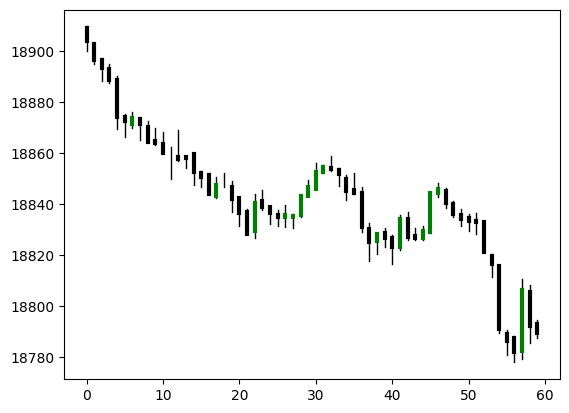

In [10]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
index+=1
step(index)
plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")
if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")
print(current_position.direction, equity_L[-1])

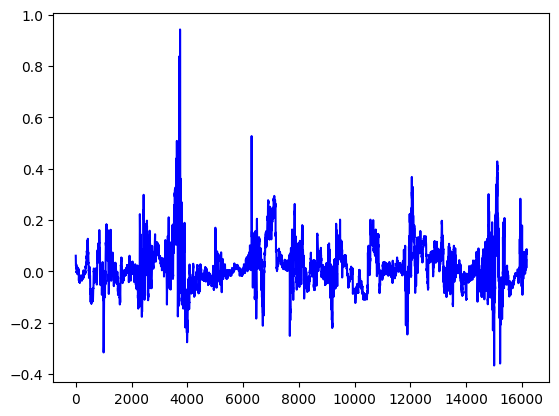

In [11]:
plt.plot([x[1]-x[0] for x in outputs], color="b")

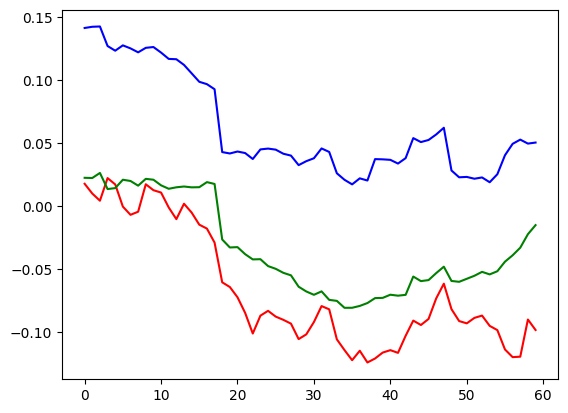

In [12]:
plt.plot([x[0] for x in outputs[-60:]], color="r")
plt.plot([x[1] for x in outputs[-60:]], color="g")
plt.plot([x[2] for x in outputs[-60:]], color="b")

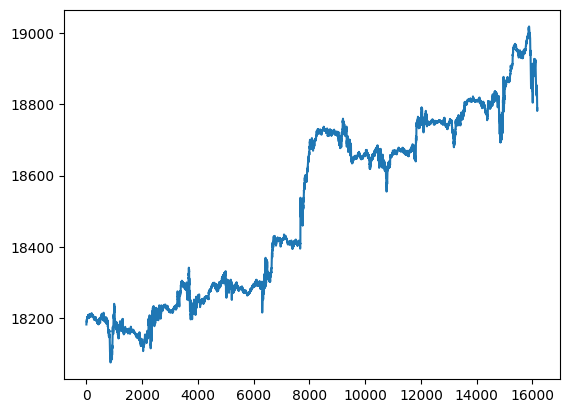

In [13]:
plt.plot([x.c for x in all_candles])

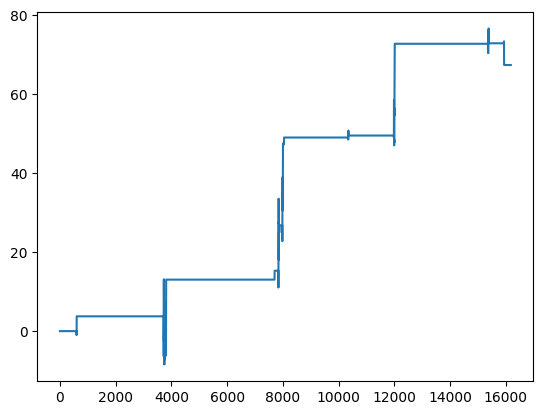

In [14]:
plt.plot(equity_L)

In [15]:
exit()